In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('seaborn-colorblind')
import scipy.stats as sps
import networkx as nx
import time
from Dist_UCB import Dist_UCB
from Dist_UCB1 import Dist_UCB1
from Dist_KL_UCB import Dist_KL_UCB
import os
from multiprocess import Pool

n_runs = 5#100
T = 1000#10000
N = 20
rwd_means = [.2, .3, .4, .5, .6]

seeds = []
myseed = 0
while len(seeds) < n_runs:
    G = nx.fast_gnp_random_graph(N, 0.5, directed=False, seed=myseed)
    if nx.is_connected(G):
        seeds.append(myseed)
    myseed += 1

sd = 0.1
distributions = [[sps.truncnorm(a=(0-rwd_means[i])/sd, b=(1-rwd_means[i])/sd, loc=rwd_means[i], scale=sd) for i in range(len(rwd_means))] for n in range(N)]
for n in range(N):
    for i in range(len(rwd_means)):
        distributions[n][i].random_state = np.random.RandomState(seed=1)
sigmas = [1, .1, .01]

In [7]:
def worker_ucb(job_runs, seeds, T, N, distributions):
    mean_regrets_dist_ucb = np.zeros((len(job_runs), T))
    for run in job_runs:
        start_run_t = time.time()
        G = nx.fast_gnp_random_graph(N, 0.5, directed=False, seed=seeds[run])
        nodes = list(G.nodes)
        for i in nodes:
            G.add_edge(i,i) 
        distucb = Dist_UCB(T, distributions, G)
        distucb.run()
        mean_regrets_dist_ucb[run - job_runs[0], :] = np.mean(distucb.regrets, axis=0)
        end_run_t = time.time()
        print(f'finished run {run} in {end_run_t - start_run_t}sec')
    return mean_regrets_dist_ucb

In [8]:
def worker_ucb1(job_runs, seeds, sigmas, T, N, distributions):
    mean_regrets_dist_ucb1 = np.zeros((len(job_runs), len(sigmas), T))
    for run in job_runs:
        start_run_t = time.time()
        G = nx.fast_gnp_random_graph(N, 0.5, directed=False, seed=seeds[run])
        nodes = list(G.nodes)
        for i in nodes:
            G.add_edge(i,i) 
        for sig in range(len(sigmas)):
            distucb1 = Dist_UCB1(T, distributions, G, beta=sigmas[sig])
            distucb1.run()
            mean_regrets_dist_ucb1[run - job_runs[0], sig, :] = np.mean(distucb1.regrets, axis=0)
        end_run_t = time.time()
        print(f'finished run {run} in {end_run_t - start_run_t}sec')
    return mean_regrets_dist_ucb1

In [9]:
def worker_kl(job_runs, seeds, sigmas, T, N, distributions):
    mean_regrets_dist_kl_ucb = np.zeros((len(job_runs), len(sigmas), T))
    for run in job_runs:
        start_run_t = time.time()
        G = nx.fast_gnp_random_graph(N, 0.5, directed=False, seed=seeds[run])
        nodes = list(G.nodes)
        for i in nodes:
            G.add_edge(i,i) 
        for sig in range(len(sigmas)):
            distkl = Dist_KL_UCB(T, distributions, G, sigma=sigmas[sig])
            distkl.run()
            mean_regrets_dist_kl_ucb[run - job_runs[0], sig, :] = np.mean(distkl.regrets, axis=0)
        end_run_t = time.time()
        print(f'finished run {run} in {end_run_t - start_run_t}sec')
    return mean_regrets_dist_kl_ucb

In [10]:
mean_regrets_dist_ucb = np.zeros((n_runs, T))
cpus = os.cpu_count()
init_time = time.time()

pool = Pool() # no need to pass in cpus, does os.cpu_count() by default
jobs = list(range(n_runs))
job_size = max(n_runs // cpus, 1)
job_chunks = [(jobs[i:i + job_size], seeds, T, N, distributions) for i in range(0, len(jobs), job_size)]
results = pool.starmap(worker_ucb, job_chunks)
pool.close()
pool.join()
mean_regrets_dist_ucb_unconcat = [result for result in results]
np.concatenate(mean_regrets_dist_ucb_unconcat, out=mean_regrets_dist_ucb)

end_run_t = time.time()

time_axis = list(range(T))
mean_regrets_over_all_runs_dist_ucb = np.mean(mean_regrets_dist_ucb, axis=0)
std_regrets_over_all_runs_dist_ucb = np.std(mean_regrets_dist_ucb, axis=0)
print(f'Total run time = {end_run_t - init_time}sec')

/home/ethan/Documents/vip-mab/code/KL_UCB/Dist_UCB.py:104: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(self.G)
/home/ethan/Documents/vip-mab/code/KL_UCB/Dist_UCB.py:104: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(self.G)


finished run 0 in 22.55639123916626sec
finished run 2 in 22.457296133041382sec
finished run 3 in 22.12143850326538sec
finished run 1 in 22.73349118232727sec
finished run 4 in 19.212193965911865sec
Total run time = 64.76568913459778sec


In [11]:
mean_regrets_dist_ucb1 = np.zeros((n_runs, len(sigmas), T))
cpus = os.cpu_count()
init_time = time.time()

pool = Pool() # no need to pass in cpus, does os.cpu_count() by default
jobs = list(range(n_runs))
job_size = max(n_runs // cpus, 1)
job_chunks = [(jobs[i:i + job_size], seeds, sigmas, T, N, distributions) for i in range(0, len(jobs), job_size)]
results = pool.starmap(worker_ucb1, job_chunks)
pool.close()
pool.join()
mean_regrets_dist_ucb1_unconcat = [result for result in results]
np.concatenate(mean_regrets_dist_ucb1_unconcat, out=mean_regrets_dist_ucb1)

end_run_t = time.time()

time_axis = list(range(T))
mean_regrets_over_all_runs_dist_ucb1 = np.mean(mean_regrets_dist_ucb1, axis=0)
std_regrets_over_all_runs_dist_ucb1 = np.std(mean_regrets_dist_ucb1, axis=0)
print(f'Total run time = {end_run_t - init_time}sec')

/home/ethan/Documents/vip-mab/code/KL_UCB/Dist_UCB1.py:106: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(self.G)
/home/ethan/Documents/vip-mab/code/KL_UCB/Dist_UCB1.py:106: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(self.G)


finished run 2 in 53.053542375564575sec
finished run 0 in 53.87390613555908sec
finished run 3 in 53.6861047744751sec
finished run 1 in 55.00908660888672sec
finished run 4 in 39.65359401702881sec
Total run time = 147.66524004936218sec


In [13]:
mean_regrets_dist_kl_ucb = np.zeros((n_runs, len(sigmas), T))
cpus = os.cpu_count()
init_time = time.time()

pool = Pool()
jobs = list(range(n_runs))
job_size = max(n_runs // cpus, 1)
job_chunks = [(jobs[i:i + job_size], seeds, sigmas, T, N, distributions) for i in range(0, len(jobs), job_size)]
results = pool.starmap(worker_kl, job_chunks)
pool.close()
pool.join()
mean_regrets_dist_kl_ucb_unconcat = [result for result in results]
np.concatenate(mean_regrets_dist_kl_ucb_unconcat, out=mean_regrets_dist_kl_ucb)

end_run_t = time.time()

time_axis = list(range(T))
mean_regrets_over_all_runs_dist_kl_ucb = np.mean(mean_regrets_dist_kl_ucb, axis=0)
std_regrets_over_all_runs_dist_kl_ucb = np.std(mean_regrets_dist_kl_ucb, axis=0)
print(f'Total run time = {end_run_t - init_time}sec')

/home/ethan/Documents/vip-mab/code/KL_UCB/Dist_KL_UCB.py:172: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(self.G)
/home/ethan/Documents/vip-mab/code/KL_UCB/Dist_KL_UCB.py:172: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(self.G)


finished run 0 in 71.85649871826172sec
finished run 2 in 80.92258095741272sec
finished run 1 in 56.17388916015625sec
finished run 3 in 65.61891293525696sec
finished run 4 in 75.5168571472168sec
Total run time = 204.32175755500793sec


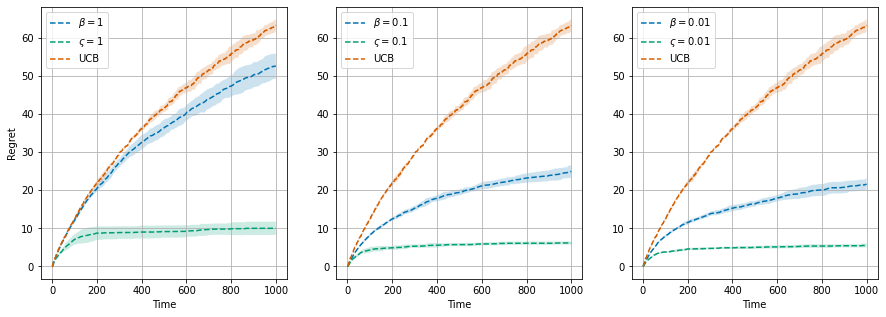

In [24]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
linestyles = ['-', '--', '--']

ax1.plot(time_axis, mean_regrets_over_all_runs_dist_ucb1[0], linestyles[1], label=r"$\beta=$" + str(sigmas[0]))
ax1.fill_between(time_axis, mean_regrets_over_all_runs_dist_ucb1[0]-std_regrets_over_all_runs_dist_ucb1[0], mean_regrets_over_all_runs_dist_ucb1[0]+std_regrets_over_all_runs_dist_ucb1[0],alpha=.2)

ax2.plot(time_axis, mean_regrets_over_all_runs_dist_ucb1[1], linestyles[1], label=r"$\beta=$" + str(sigmas[1]))
ax2.fill_between(time_axis, mean_regrets_over_all_runs_dist_ucb1[1]-std_regrets_over_all_runs_dist_ucb1[1], mean_regrets_over_all_runs_dist_ucb1[1]+std_regrets_over_all_runs_dist_ucb1[1],alpha=.2)

ax3.plot(time_axis, mean_regrets_over_all_runs_dist_ucb1[2], linestyles[1], label=r"$\beta=$" + str(sigmas[2]))
ax3.fill_between(time_axis, mean_regrets_over_all_runs_dist_ucb1[2]-std_regrets_over_all_runs_dist_ucb1[2], mean_regrets_over_all_runs_dist_ucb1[2]+std_regrets_over_all_runs_dist_ucb1[2],alpha=.2)

ax1.plot(time_axis, mean_regrets_over_all_runs_dist_kl_ucb[0], linestyles[1], label=r"$\varsigma=$" + str(sigmas[0]))
ax1.fill_between(time_axis, mean_regrets_over_all_runs_dist_kl_ucb[0]-std_regrets_over_all_runs_dist_kl_ucb[0], mean_regrets_over_all_runs_dist_kl_ucb[0]+std_regrets_over_all_runs_dist_kl_ucb[0],alpha=.2)

ax2.plot(time_axis, mean_regrets_over_all_runs_dist_kl_ucb[1], linestyles[1], label=r"$\varsigma=$" + str(sigmas[1]))
ax2.fill_between(time_axis, mean_regrets_over_all_runs_dist_kl_ucb[1]-std_regrets_over_all_runs_dist_kl_ucb[1], mean_regrets_over_all_runs_dist_kl_ucb[1]+std_regrets_over_all_runs_dist_kl_ucb[1],alpha=.2)

ax3.plot(time_axis, mean_regrets_over_all_runs_dist_kl_ucb[2], linestyles[1], label=r"$\varsigma=$" + str(sigmas[2]))
ax3.fill_between(time_axis, mean_regrets_over_all_runs_dist_kl_ucb[2]-std_regrets_over_all_runs_dist_kl_ucb[2], mean_regrets_over_all_runs_dist_kl_ucb[2]+std_regrets_over_all_runs_dist_kl_ucb[2],alpha=.2)

ax1.plot(time_axis, mean_regrets_over_all_runs_dist_ucb, linestyles[2], label="UCB")
ax1.fill_between(time_axis, mean_regrets_over_all_runs_dist_ucb-std_regrets_over_all_runs_dist_ucb, mean_regrets_over_all_runs_dist_ucb+std_regrets_over_all_runs_dist_ucb,alpha=.2)

ax2.plot(time_axis, mean_regrets_over_all_runs_dist_ucb, linestyles[2], label="UCB")
ax2.fill_between(time_axis, mean_regrets_over_all_runs_dist_ucb-std_regrets_over_all_runs_dist_ucb, mean_regrets_over_all_runs_dist_ucb+std_regrets_over_all_runs_dist_ucb,alpha=.2)

ax3.plot(time_axis, mean_regrets_over_all_runs_dist_ucb, linestyles[2], label="UCB")
ax3.fill_between(time_axis, mean_regrets_over_all_runs_dist_ucb-std_regrets_over_all_runs_dist_ucb, mean_regrets_over_all_runs_dist_ucb+std_regrets_over_all_runs_dist_ucb,alpha=.2)

ax1.legend(loc="upper left")
ax1.grid()
ax1.set_xlabel("Time")
ax1.set_ylabel("Regret")
ax2.legend(loc="upper left")
ax2.grid()
ax2.set_xlabel("Time")
ax3.legend(loc="upper left")
ax3.grid()
ax3.set_xlabel("Time")
plt.savefig("dist_KL_vs_dist_UCB1_vs_dist_UCB.pdf", bbox_inches='tight')